# Machine Learning Human Skin Detection
---
Simle ML model for human skin detection with application of:
* **pixel classification** based on:
    * only one pixel (i.e. values of R, G and B)
    * 5x5 neighbourhood of pixel (i.e. 5x5x3=75 values)
    * 9x9 neighbourhood of pixel (i.e. 9x9x3=243 values)
    * 13x13 neighbourhood of pixel (i.e. 13x13x3=507 values)
* **DecisionTree model**

In [1]:
import os
import csv
import pickle

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from src.face_detector import inference

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by access

In [2]:
def show_images(images, titles, suptitle='Images'):
    assert (len(images) == len(titles)), 'Lists of images and titles of images must have the same length!'
    
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    
    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image)
        ax[i].set_title(title)
        ax[i].axis('off')
    
    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

## Data gathering
---
First detect faces on input images and their ground truths respectively.<br />
Load all detected faces with their ground truth masks. Then for each pixel in ground truth extract its neighbourhood from input image.<br />
Save every 3-rd pixel into validation set and others into train.

In [3]:
INPUT_IMG_PATH = 'skin_color_images/input'
GROUND_TRUTH_PATH = 'skin_color_images/ground_truth'

FACES_PATH = 'skin_color_images/faces'
FACES_GT_PATH = 'skin_color_images/faces_gt'

N = (5, 5)  # neighbourhood
FACTOR = 1.  # factor for images shrinking (to reduce training time)

In [4]:
if len(os.listdir(FACES_PATH)) == 0:
    ctr = 0
    t = tqdm(os.listdir(INPUT_IMG_PATH))
    for img_name in t:
        
        t.set_postfix_str(f'Curr. img.: {img_name} | Faces found: {ctr}')
        img = Image.open(f'{INPUT_IMG_PATH}/{img_name}')
        img_arr = np.array(img)
        gt = Image.open(f'{GROUND_TRUTH_PATH}/{img_name.replace(".jpg", ".png")}')
        gt_arr = np.array(gt)
        
        try:
            faces, _ = inference(img_arr)
            for face in faces:
                fx1, fy1, fx2, fy2 = tuple(face[2:])
                
                face_img = Image.fromarray(img_arr[fy1:fy2, fx1:fx2])
                face_gt = Image.fromarray(gt_arr[fy1:fy2, fx1:fx2])
                face_img = face_img.resize((int(face_img.width*FACTOR), int(face_img.height*FACTOR)))
                face_gt = face_gt.resize((int(face_gt.width*FACTOR), int(face_gt.height*FACTOR)),
                                         resample=Image.NEAREST)
                face_img.save(f'{FACES_PATH}/face{ctr}.png')
                face_gt.save(f'{FACES_GT_PATH}/face{ctr}.png')
                
                ctr += 1
        except:
            pass

In [5]:
DATA_PATH = f'skin_color_images/data{N[0]}x{N[1]}'

In [6]:
if not os.path.exists(f'{DATA_PATH}_val.csv'):
    ctr = 0
    with open(f'{DATA_PATH}_val.csv', 'w') as f:
        pass
    with open(f'{DATA_PATH}_train.csv', 'w') as f:
        pass

    for img_name in tqdm(os.listdir(FACES_PATH)):
        img = Image.open(f'{FACES_PATH}/{img_name}')
        gt = Image.open(f'{FACES_GT_PATH}/{img_name}').convert('L')

        img_arr = np.zeros((img.size[1] + N[0]-1, img.size[0] + N[1]-1, 3))
        off0, off1 = N[0]//2, N[1]//2
        img_arr[off0:-off0, off1:-off1] = np.array(img)/255.
        gt_arr = np.array(gt)/255.

        for i in range(gt_arr.shape[0]):
            for j in range(gt_arr.shape[1]):
                file = f'{DATA_PATH}_{"val" if ctr%3 == 0 else "train"}.csv'
                with open(file, 'a') as f:
                    csv.writer(f).writerow([*img_arr[i:i+N[0], j:j+N[1]].reshape(-1), gt_arr[i, j]])
                ctr += 1

## 3 models
---
SGDClassifier, DecisionTreeClassifier and RandomForestClassifier models.

In [7]:
with open(f'{DATA_PATH}_train.csv', 'r') as f:
    xy_train = np.array(list(csv.reader(f)))
X_train = xy_train[:, :-1].astype(float)
y_train = xy_train[:, -1].astype(float).astype(int)
del xy_train

In [8]:
with open(f'{DATA_PATH}_val.csv', 'r') as f:
    xy_val = np.array(list(csv.reader(f)))
X_val = xy_val[:, :-1].astype(float)
y_val = xy_val[:, -1].astype(float).astype(int)
del xy_val

In [9]:
print('Train len:', len(X_train))
print('Valid. len:', len(X_val))

Train len: 682998
Valid. len: 341499


SGD

In [10]:
model_path = 'src/models/sgd_hskin.pkl'
if not os.path.exists(model_path):
    sgd = SGDClassifier(class_weight='balanced')
    sgd.fit(X_train, y_train)
    with open(model_path, 'wb') as f:
        pickle.dump(sgd, f)
else:
    with open(model_path, 'rb') as f:
        sgd = pickle.load(f)
sgd

SGDClassifier(class_weight='balanced')

In [11]:
y_pred = sgd.predict(X_val)

acc = accuracy_score(y_true=y_val, y_pred=y_pred)
f0, f1 = f1_score(y_true=y_val, y_pred=y_pred, labels=[0, 1], average=None)

In [12]:
acc, f0, f1

(0.8596013458311738, 0.7713569037377561, 0.8986984998943588)

Decision Tree

In [13]:
model_path = 'src/models/dt_hskin.pkl'
if not os.path.exists(model_path):
    dt = DecisionTreeClassifier(class_weight='balanced')
    dt.fit(X_train, y_train)
    with open(model_path, 'wb') as f:
        pickle.dump(dt, f)
else:
    with open(model_path, 'rb') as f:
        dt = pickle.load(f)
dt

DecisionTreeClassifier(class_weight='balanced')

In [14]:
y_pred = dt.predict(X_val)

acc = accuracy_score(y_true=y_val, y_pred=y_pred)
f0, f1 = f1_score(y_true=y_val, y_pred=y_pred, labels=[0, 1], average=None)

In [15]:
acc, f0, f1

(0.9236015332402144, 0.8586229692969622, 0.9476583690436066)

Random Forest

In [16]:
model_path = 'src/models/rf_hskin.pkl'
if not os.path.exists(model_path):
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    with open(model_path, 'wb') as f:
        pickle.dump(rf, f)
else:
    with open(model_path, 'rb') as f:
        rf = pickle.load(f)
rf

RandomForestClassifier(class_weight='balanced')

In [17]:
y_pred = rf.predict(X_val)

acc = accuracy_score(y_true=y_val, y_pred=y_pred)
f0, f1 = f1_score(y_true=y_val, y_pred=y_pred, labels=[0, 1], average=None)

In [18]:
acc, f0, f1

(0.9592443901739097, 0.9241418402607454, 0.9721374748760819)

## Examples
---
Examples of skin detection ground truth prediction.

In [19]:
def detect_skin(image, model, return_array=False):
    
    img_arr = np.zeros((image.size[1] + N[0]-1, image.size[0] + N[1]-1, 3))
    off0, off1 = N[0]//2, N[1]//2
    img_arr[off0:-off0, off1:-off1] = np.array(image)/255.
    gt_arr = np.zeros((image.size[1], image.size[0]))
    
    features_list = list()
    for i in range(gt_arr.shape[0]):
        for j in range(gt_arr.shape[1]):
            features_list.append(img_arr[i:i+N[0], j:j+N[1]].reshape(-1))
    
    features = np.array(features_list)
    preds = model.predict(features)
    
    pred_img_arr = preds.reshape(gt_arr.shape)
    pred_img_arr[pred_img_arr==1] = 255
    pred_img_arr = pred_img_arr.astype(float)
    
    if return_array:
        return pred_img_arr
    
    pred_img = Image.fromarray(pred_img_arr)
    return pred_img

In [20]:
img1 = Image.open('skin_color_images/input/w_sexy.jpg')
skn1 = Image.open('skin_color_images/ground_truth/w_sexy.png')
res1_sgd = detect_skin(img1, model=sgd)
res1_dt = detect_skin(img1, model=dt)
res1_rf = detect_skin(img1, model=rf)

img2 = Image.open('skin_color_images/input/sara_badr.jpg')
skn2 = Image.open('skin_color_images/ground_truth/sara_badr.png')
res2_sgd = detect_skin(img2, model=sgd)
res2_dt = detect_skin(img2, model=dt)
res2_rf = detect_skin(img2, model=rf)

img3 = Image.open('skin_color_images/input/josh-hartnett-Poster-thumb.jpg')
skn3 = Image.open('skin_color_images/ground_truth/josh-hartnett-Poster-thumb.png')
res3_sgd = detect_skin(img3, model=sgd)
res3_dt = detect_skin(img3, model=dt)
res3_rf = detect_skin(img3, model=rf)

img4 = Image.open('detected_faces/face4315.png')
res4_sgd = detect_skin(img4, model=sgd)
res4_dt = detect_skin(img4, model=dt)
res4_rf = detect_skin(img4, model=rf)

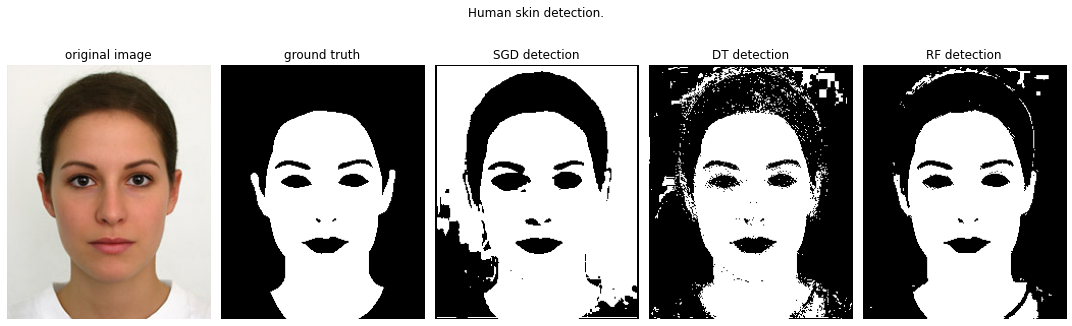

In [21]:
show_images([img1, skn1, res1_sgd, res1_dt, res1_rf],
            ['original image', 'ground truth', 'SGD detection', 'DT detection', 'RF detection'],
            suptitle='Human skin detection.')

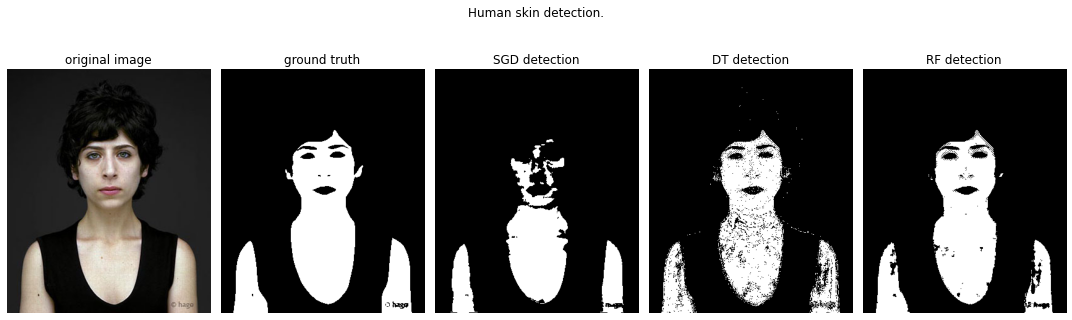

In [22]:
show_images([img2, skn2, res2_sgd, res2_dt, res2_rf],
            ['original image', 'ground truth', 'SGD detection', 'DT detection', 'RF detection'],
            suptitle='Human skin detection.')

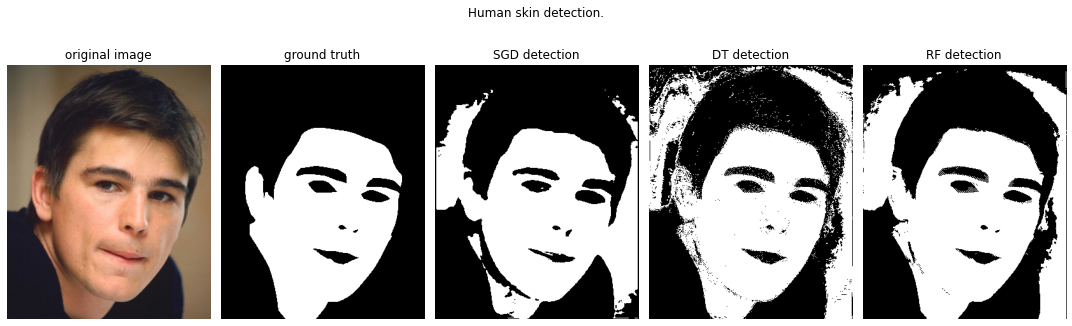

In [23]:
show_images([img3, skn3, res3_sgd, res3_dt, res3_rf],
            ['original image', 'ground truth', 'SGD detection', 'DT detection', 'RF detection'],
            suptitle='Human skin detection.')

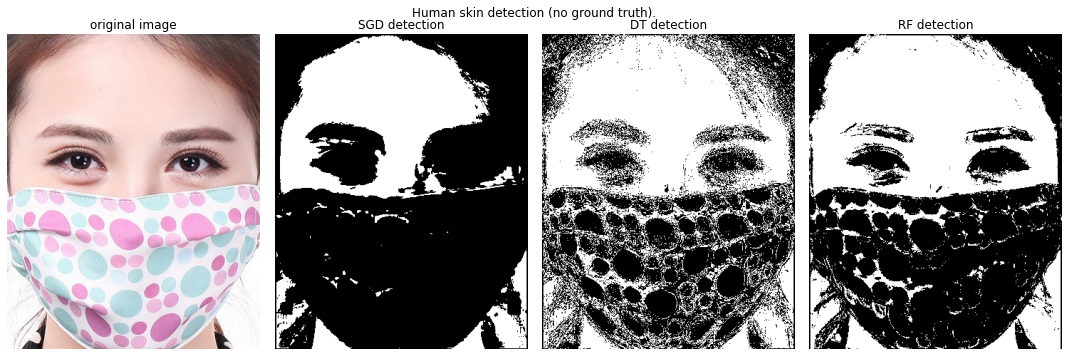

In [24]:
show_images([img4, res4_sgd, res4_dt, res4_rf],
            ['original image', 'SGD detection', 'DT detection', 'RF detection'],
            suptitle='Human skin detection (no ground truth).')